# Into to Baysean Neural Networks

https://matthewmcateer.me/blog/a-quick-intro-to-bayesian-neural-networks/

A quick intro to Bayesian neural networks
Making neural networks shrug their shoulders
JANUARY 13, 2019

Oct 9, 2021

The way he build the prior and posterior models is of interest. And is neg-log-prob model avoids the
tensor has no log_prog method error that bedeviled the "Folowing Probabilistic Bayesian Neural Networks"
(https://keras.io/examples/keras_recipes/bayesian_neural_networks/) example before I broke the tensor_dataset
into just numpy arrays as inputs.



In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions


In [42]:
xname="sm_0.67"; yname="halo_mass"
xname="stellarmass"; yname="halo_mass"; x2name="central_sm"

gal_df = pd.read_csv("Data/galaxies_near_clusters_0.3-0.6.csv") 
cluster_data = pd.read_csv("Data/cluster_data_0.3-0.6.csv")
x=cluster_data[xname]; 
y=cluster_data[yname];
x2=cluster_data[x2name]

x = np.asarray(x).astype('float32')
x2 = np.asarray(x2).astype('float32')
y = np.asarray(y).astype('float32')

n=200
x_tr=x[0:n]; x_te=x[n:]
x2_tr=x2[0:n]; x2_te=x[n:]
y_tr=y[0:n]; y_te=x[n:]
xx_tr=np.array([x_tr,x2_tr,y_tr]); xx_te=np.array([x_te,x2_te,y_te])
print("xx_tr: {}".format(xx_tr.shape))
print("y_tr: {}".format(y_tr.shape))

train_dataset = [x_tr, x2_tr, y_tr]
test_dataset = [x_te, x2_te, y_te]

xx_tr: (3, 200)
y_tr: (200,)


In [43]:

train_size = n
noise = 1.0


In [44]:
from keras import backend as K
from keras import activations, initializers
from keras.layers import Layer
import tensorflow as tf

def mixture_prior_params(sigma_1, sigma_2, pi, return_sigma=False):
    params = K.variable([sigma_1, sigma_2, pi], name='mixture_prior_params')
    sigma = np.sqrt(pi * sigma_1 ** 2 + (1 - pi) * sigma_2 ** 2)
    return params, sigma
  
def log_mixture_prior_prob(w):
    comp_1_dist = tf.distributions.Normal(0.0, prior_params[0])
    comp_2_dist = tf.distributions.Normal(0.0, prior_params[1])
    comp_1_weight = prior_params[2]
    return K.log(comp_1_weight * comp_1_dist.prob(w) + (1 - comp_1_weight) * comp_2_dist.prob(w))
  
# Mixture prior parameters shared across DenseVariational layer instances
prior_params, prior_sigma = mixture_prior_params(sigma_1=1.0, sigma_2=0.1, pi=0.2)

Our model is a neural network with two DenseVariational hidden layers, each having 20 units, and one DenseVariational output layer with one unit. Instead of modeling a full probability distribution 
p(y∣x,w) as output the network simply outputs the mean of the corresponding Gaussian distribution. In other words, we do not model aleatoric uncertainty here and assume it is known. We only model epistemic uncertainty via the DenseVariational layers.

Since the training dataset has only 32 examples we train the network with all 32 examples per epoch so that the number of batches per epoch is 1. For other configurations, the complexity cost (kl_loss) must be weighted by 
1/M as described in section 3.4 of the paper where 
M is the number of mini-batches per epoch.



In [45]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
  
batch_size = train_size
num_batches = train_size / batch_size
kl_loss_weight = 1.0 / num_batches
  
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def  posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])
  
# Build model.
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tfp.layers.DenseVariational(units=20,
                                make_posterior_fn=posterior_mean_field,
                                make_prior_fn=prior_trainable,
                                kl_weight=kl_loss_weight,
                                activation='relu'),
    tfp.layers.DenseVariational(units=20,
                                make_posterior_fn=posterior_mean_field,
                                make_prior_fn=prior_trainable,
                                kl_weight=kl_loss_weight,
                                activation='relu'),
    tfp.layers.DenseVariational(units=1,
                                make_posterior_fn=posterior_mean_field,
                                make_prior_fn=prior_trainable,
                                kl_weight=kl_loss_weight)
])

The network can now be trained with a Gaussian negative log likelihood function (neg_log_likelihood) as loss function assuming a fixed standard deviation (noise). This corresponds to the likelihood cost, the last term in equation 3.

In [53]:
from keras import callbacks, optimizers

def neg_log_likelihood(y_true, y_pred, sigma=noise):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_true))

negloglik = lambda y, rv_y: -rv_y.log_prob(y)
# Do inference.
# model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
# model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), metrics=['mse'])

model.compile(loss=neg_log_likelihood, optimizer=Adam(lr=0.03), metrics=['mse'])
model.fit(x, y, batch_size=batch_size, epochs=1500, verbose=0);

When calling model.predict we draw a random sample from the variational posterior distribution and use it to compute the output value of the network. This is equivalent to obtaining the output from a single member of a hypothetical ensemble of neural networks. Drawing 500 samples means that we get predictions from 500 ensemble members. From these predictions we can compute statistics such as the mean and standard deviation. In our example, the standard deviation is a measure of epistemic uncertainty.

In [54]:
from tqdm import tqdm
from tqdm import trange

X_test  = np.arange(11.6,13,0.1).reshape(-1, 1)

y_pred_list = []
for i in trange(500):
    y_pred = model.predict(X_test)
    y_pred_list.append(y_pred)
    
y_preds = np.concatenate(y_pred_list, axis=1)
y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)
  


100%|██████████| 500/500 [00:28<00:00, 17.41it/s]


(15,) (15,)


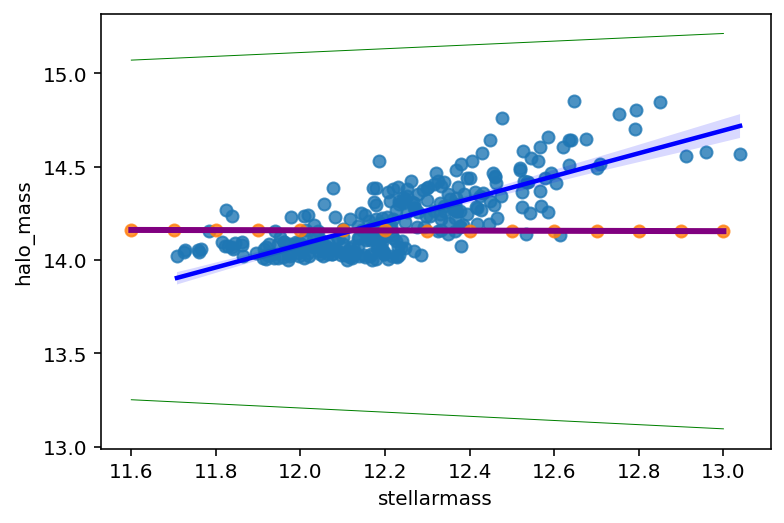

In [55]:
X_test  = np.arange(11.6,13,0.1).reshape(-1, 1)
X_test=X_test[:,0]
print(X_test.shape,y_mean.shape)
inv_df=pd.DataFrame(data={xname:X_test,yname:y_mean})
sns.regplot(x=xname,y=yname, data=cluster_data, line_kws={"color": "blue"})
sns.regplot(x=xname,y=yname, data=inv_df, line_kws={"color": "orange"})

plt.plot(X_test, y_mean,'purple', label='mean', linewidth=3);
plt.plot(X_test, y_mean-y_sigma,'g',linewidth=0.5);
plt.plot(X_test, y_mean+y_sigma,'g',linewidth=0.5);
